Previous: [pipeline_preprocess](pipeline_preprocess.ipynb)  ::: Next [pipeline_tuning](pipeline_tuning.ipynb) 

---
## How visual stimuli are synchronized and matched
The stimulus computer and acquisition computers run on different clocks.  The table `preprocess.Sync` matches simultaneously recorded signals in both systems to synchronize the two recordings.

The field `frame_times` in `preprocess.Sync` contains the times of the two-photon frames on the same clock as the `flip_times` in `vis.Trial`.  Furthermore, it has the reference to the `vis.Session`'s `psy.id` and the trial ids of the first and last trial that were played during the given scan (`preprocess.Sync` has 1-to-1 correspondence scans). 

In [20]:
%pylab inline
pylab.rcParams['figure.figsize'] = (6, 6)
import datajoint as dj
from pipeline import preprocess, vis


Populating the interactive namespace from numpy and matplotlib


All kinds of stimuli are synchronized and matched exactly the same way using stimulus-neutral tables `preprocess.Sync`, `vis.Session`, `vis.Trial`, and `vis.Condition`.  All information pertaining to specific stimuli is stored in tables immediately belore `vis.Condition`.

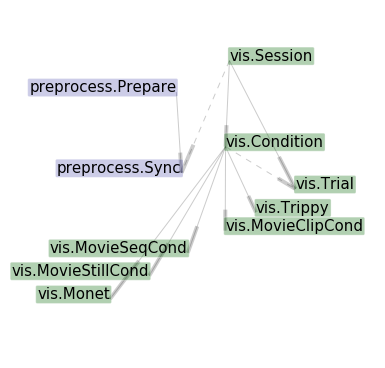

In [23]:
(dj.ERD(preprocess.Sync)-1+vis.Trial+(dj.ERD(vis.Condition)+1)).draw()

In [24]:
preprocess.Sync().heading

# 
animal_id            : int                          # id number
session              : smallint                     # session index for the mouse
scan_idx             : smallint                     # number of TIFF stack file
---
psy_id               : smallint unsigned            # unique psy session number
first_trial          : int                          # first trial index from psy.Trial overlapping recording
last_trial           : int                          # last trial index from psy.Trial overlapping recording
signal_start_time    : double                       # (s) signal start time on stimulus clock
signal_duration      : double                       # (s) signal duration on stimulus time
frame_times=null     : longblob                     # times of frames and slices
sync_ts=CURRENT_TIMESTAMP : timestamp                    # automatic

In [25]:
vis.Trial().heading

# visual stimulus trial
animal_id            : int                          # id (internal to database)
psy_id               : smallint unsigned            # unique psy session number
trial_idx            : int                          # trial index within sessions
---
cond_idx             : smallint unsigned            # condition index
flip_times           : mediumblob                   # (s) row array of flip times
last_flip_count      : int unsigned                 # the last flip number in this trial
trial_ts=CURRENT_TIMESTAMP : timestamp                    # automatic

---

Let's pick an arbitrary scan that has Monet trials in it.

In [26]:
scan_keys = list((preprocess.Sync() & vis.Monet()).fetch.keys())   # get the keys of all scans with Monet
key = scan_keys[10]   # let's pick an arbitrary scan
key

OrderedDict([('animal_id', 7816), ('session', 1), ('scan_idx', 34)])

Joining `preprocess.Sync*vis.Trial` provides all the trials that were played for the given scan.  
Use the `first_trial` and `last_trial` fields to only include trials that played between the start time and the stop time of the scan.

In [27]:
matched_trials = preprocess.Sync()*vis.Trial() & 'trial_idx between first_trial and last_trial' & key
matched_trials 

animal_id,session,scan_idx,psy_id,trial_idx,first_trial,last_trial,signal_start_time,signal_duration,sync_ts,cond_idx,last_flip_count,trial_ts
7816,1,34,5,259,259,288,1.45515e+09,1844.61,2016-07-07 14:15:37,28,970152,2016-02-10 19:22:32
7816,1,34,5,260,259,288,1.45515e+09,1844.61,2016-07-07 14:15:37,20,973752,2016-02-10 19:23:32
7816,1,34,5,261,259,288,1.45515e+09,1844.61,2016-07-07 14:15:37,3,977352,2016-02-10 19:24:32
7816,1,34,5,262,259,288,1.45515e+09,1844.61,2016-07-07 14:15:37,5,980952,2016-02-10 19:25:32
7816,1,34,5,263,259,288,1.45515e+09,1844.61,2016-07-07 14:15:37,22,984552,2016-02-10 19:26:32
7816,1,34,5,264,259,288,1.45515e+09,1844.61,2016-07-07 14:15:37,15,988152,2016-02-10 19:27:32
7816,1,34,5,265,259,288,1.45515e+09,1844.61,2016-07-07 14:15:37,21,991752,2016-02-10 19:28:32


---
Now `matched_trials` contains almost all the information about the trials except the bitmaps stimulus conditions themselves, which are stored in vis.Monet and vis.MonetLookup()
Let's join them into the the same relation:

In [28]:
matched_trials *= vis.Monet()*vis.MonetLookup()
matched_trials

animal_id,session,scan_idx,psy_id,trial_idx,cond_idx,moving_noise_version,moving_noise_paramhash,first_trial,last_trial,signal_start_time,signal_duration,sync_ts,last_flip_count,trial_ts,rng_seed,luminance,contrast,tex_ydim,tex_xdim,spatial_freq_half,spatial_freq_stop,temp_bandwidth,ori_on_secs,ori_off_secs,n_dirs,ori_bands,ori_modulation,speed,frame_downsample,moving_noise_lookup_ts
7816,1,34,5,259,28,5,cfa6185f67,259,288,1.45515e+09,1844.61,2016-07-07 14:15:37,970152,2016-02-10 19:22:32,28.0,10.0,0.95,90,160,0.04,0.08,4.0,1.0,2.75,16,2,1.0,20.0,1,2016-02-10 14:01:19
7816,1,34,5,260,20,5,175c826543,259,288,1.45515e+09,1844.61,2016-07-07 14:15:37,973752,2016-02-10 19:23:32,20.0,10.0,0.95,90,160,0.04,0.08,4.0,1.0,2.75,16,2,1.0,20.0,1,2016-02-10 13:56:30
7816,1,34,5,261,3,5,209c12cf0f,259,288,1.45515e+09,1844.61,2016-07-07 14:15:37,977352,2016-02-10 19:24:32,3.0,10.0,0.95,90,160,0.04,0.08,4.0,1.0,2.75,16,2,1.0,20.0,1,2016-02-10 13:45:48
7816,1,34,5,262,5,5,cf2270a1c3,259,288,1.45515e+09,1844.61,2016-07-07 14:15:37,980952,2016-02-10 19:25:32,5.0,10.0,0.95,90,160,0.04,0.08,4.0,1.0,2.75,16,2,1.0,20.0,1,2016-02-10 13:46:59
7816,1,34,5,263,22,5,b2dab08578,259,288,1.45515e+09,1844.61,2016-07-07 14:15:37,984552,2016-02-10 19:26:32,22.0,10.0,0.95,90,160,0.04,0.08,4.0,1.0,2.75,16,2,1.0,20.0,1,2016-02-10 13:57:40
7816,1,34,5,264,15,5,9955ec108a,259,288,1.45515e+09,1844.61,2016-07-07 14:15:37,988152,2016-02-10 19:27:32,15.0,10.0,0.95,90,160,0.04,0.08,4.0,1.0,2.75,16,2,1.0,20.0,1,2016-02-10 13:53:20
7816,1,34,5,265,21,5,73a3b25df3,259,288,1.45515e+09,1844.61,2016-07-07 14:15:37,991752,2016-02-10 19:28:32,21.0,10.0,0.95,90,160,0.04,0.08,4.0,1.0,2.75,16,2,1.0,20.0,1,2016-02-10 13:57:05


Now `matched_trials` contains all the infromation about all the trials for the scan identify by `key`.
All that remains to be done is to fetch the contents.
```python
info = match_trials.fetch()   
```

---
Next [pipeline_tuning](pipeline_tuning.ipynb) 